In [226]:
###Packages & Setup###

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

In [192]:
###Load in data###

avocado = pd.read_csv('avocado.csv')
cities = pd.read_csv('uscities.csv')
country = gpd.read_file('gz_2010_us_040_00_5m.json')

In [193]:
###Standardizing city names so we get all of the cities we want when we merge###

cities.city = cities.city.str.replace(' ', '').str.lower()
avocado.region = avocado.region.str.lower()

###Merge###

data = avocado.merge(cities, left_on='region', right_on='city', how='left')

In [213]:
###Cleaning up data###

country = country[(country['NAME'] != 'Alaska') & (country['NAME'] != 'Puerto Rico') & (country['NAME'] != 'Hawaii')]

data = data[(data['city'] != 'west') & (data['city'] != 'california') & (data['city'] != 'plains')
            & (data['city'] != 'northeast') & (data['population'] > 100000) & (data['state_name'] != 'Maine')]
data = data.loc[~((data['state_name'] == 'North Carolina') & (data['city'] == 'jacksonville')),:]
data = data.loc[~((data['state_name'] == 'Georgia') & (data['city'] == 'columbus')),:]

In [214]:
###Zipping Latitude and Longitude###

data = data[(data['lng'] < 0) & (data['lng'] > -140)]
data['coordinates'] = [
    Point(long, lat) 
    for long, lat 
    in zip(data['lng'], data['lat'])
]
data = gpd.GeoDataFrame(data, geometry='coordinates')

(-127.62233795, -64.06073105, 23.302718150000004, 50.62634085)

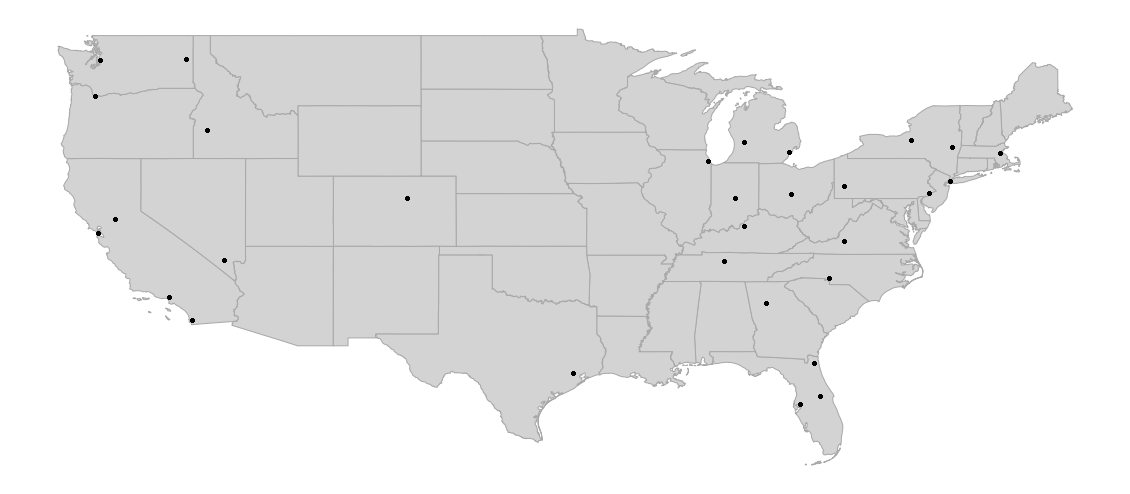

In [232]:
###Plotting###

fig, ax = plt.subplots(1, figsize=(20, 20))

country.plot(color='#D3D3D3', ax=ax, edgecolor='#A9A9A9')
data.plot(color='black', markersize=10, ax=ax)
plt.axis('off')

In [248]:
###Machine Learning###

data1 = data[['Date', 'AveragePrice', 'Total Volume', 'city', 'year', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'population', 'density']]

features = data1.loc[:, data1.columns != 'AveragePrice']
labels = data1['AveragePrice']
features = pd.get_dummies(features)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.25)

model = DecisionTreeRegressor()
model.fit(features_train, labels_train)

train_predictions = model.predict(features_train)
test_predictions = model.predict(features_test)

train_acc = mean_squared_error(labels_train, train_predictions)
train_acc

2.7228926708812044e-34

In [249]:
test_acc = mean_squared_error(labels_test, test_predictions)

0.0435614201183432